In [1]:
import torch
from torch import nn
from torch.distributions import Poisson
from einops import repeat
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

In [2]:
class ConstantLocsPrior:
    def __init__(self, low, high, offset):
        self.low = low
        self.high = high
        self.offset = offset

    def sample(self, sample_shape):
        mid_point = (self.low + self.high) / 2
        m = sample_shape[-1]
        mid_point = torch.stack([mid_point + self.offset * i for i in range(m)], dim=0)
        assert (mid_point <= self.high).all()
        return torch.ones(sample_shape[:-1]).unsqueeze(-1).unsqueeze(-1) * mid_point
    

class CatalogPrior:
    def __init__(
        self,
        num_objects: int,
        img_height: int,
        img_width: int,
        flux_list: list[float],
        locs_offset: float,
    ):
        self.num_objects = num_objects
        self.img_height = img_height
        self.img_width = img_width
        assert len(flux_list) == num_objects
        self.fluxes = torch.tensor(flux_list)
        self.loc_prior = ConstantLocsPrior(torch.zeros(2), 
                                           torch.tensor((self.img_height, self.img_width)),
                                           offset=locs_offset)

    def sample(
        self,
        num_catalogs,
    ):
        fluxes = repeat(self.fluxes, "m -> b m", b=num_catalogs)  # (n_catalogs, m)
        locs = self.loc_prior.sample(
            [num_catalogs, self.num_objects]
        )  # (n_catalogs, m, 2)
        return {
            "count": torch.full((num_catalogs, ), fill_value=self.num_objects),
            "fluxes": fluxes, 
            "locs": locs
        }



class ImageSimulator(nn.Module):
    def __init__(
        self,
        img_height: int,
        img_width: int,
        num_objects: int,
        locs_offset: float,
        flux_list: list[float],
        psf_stdev: float,
        background_intensity: float,
    ):
        super().__init__()

        self.img_height = img_height
        self.img_width = img_width
        self.num_objects = num_objects

        self.flux_list = flux_list
        self.psf_stdev = psf_stdev
        self.background_intensity = background_intensity

        self.catalog_prior = CatalogPrior(num_objects=num_objects,
                                          img_height=img_height,
                                          img_width=img_width,
                                          flux_list=flux_list,
                                          locs_offset=locs_offset)

        self.register_buffer("dummy_param", torch.zeros(0))
        self.register_buffer("psf_marginal_h",
                             (0.5 + torch.arange(self.img_height, dtype=torch.float32)).view(1, self.img_height, 1, 1))
        self.register_buffer("psf_marginal_w",
                             (0.5 + torch.arange(self.img_width, dtype=torch.float32)).view(1, 1, self.img_width, 1))

    @property
    def device(self):
        return self.dummy_param.device

    def psf(self, loc_h, loc_w):
        logpsf = -(
            (self.psf_marginal_h - loc_h.view(-1, 1, 1, self.num_objects)) ** 2
            + (self.psf_marginal_w - loc_w.view(-1, 1, 1, self.num_objects)) ** 2
        ) / (2 * self.psf_stdev ** 2)
        return torch.exp(logpsf - logpsf.logsumexp(dim=(1, 2), keepdim=True))
    
    def _generate(self, batch_size):
        tile_cat = self.catalog_prior.sample(num_catalogs=batch_size)
        tile_cat = {k: v.to(device=self.device) for k, v in tile_cat.items()}
        psf = self.psf(tile_cat["locs"][:, :, 0], tile_cat["locs"][:, :, 1])  # (b, h, w, m)
        source_intensities = (tile_cat["fluxes"].view(batch_size, 1, 1, self.num_objects) * psf).sum(dim=3)  # (b, h, w)
        total_intensities = source_intensities + self.background_intensity
        images = Poisson(total_intensities).sample()
        return {
            **tile_cat, 
            "psf": psf,
            "source_intensities": source_intensities,
            "total_intensities": total_intensities, 
            "images": images
        }
    
    def generate(self, batch_size, *, seed=None):
        if seed is not None:
            with torch.random.fork_rng(devices=["cpu", self.device]):
                torch.manual_seed(seed)
                output = self._generate(batch_size)
        else:
            output = self._generate(batch_size)
        return output


In [3]:
def extract_psf(psf_tensor):
    return [psf_tensor[..., i].numpy() for i in range(psf_tensor.shape[-1])]

In [4]:
def test_offset_and_posterior(locs_offset, seed):
    img_size = 4
    num_objects = 2
    background_intensity=50.0
    img_simulator = ImageSimulator(img_height=img_size, 
                                    img_width=img_size, 
                                    num_objects=num_objects, 
                                    locs_offset=locs_offset,
                                    flux_list=[1000.0, 500.0], 
                                    psf_stdev=1.0, 
                                    background_intensity=background_intensity)
    outputs = img_simulator.generate(batch_size=2, seed=seed)
    print("+" * 100)
    print(f"offset: {locs_offset:.2f}")
    print("=" * 100)
    print("sampling:")
    # stan_model = CmdStanModel(stan_file="./overlap_posterior.stan")
    stan_model = CmdStanModel(stan_file="./1or2_posterior.stan")
    mcmc_results = stan_model.sample(data={
        "num_objects": num_objects,
        "img_size": img_size,
        "img": outputs["images"][0].int().numpy(),
        "psf": extract_psf(outputs["psf"][0]),
        "flux_alpha": 10.0,
        "flux_beta": 0.01,
        "background_intensity": background_intensity,
    },
    chains=4,
    seed=seed,
    iter_warmup=3000,
    iter_sampling=5000,
    show_progress=False)
    print("=" * 100)
    print("diagnose:")
    print(mcmc_results.summary())
    print(mcmc_results.diagnose())
    print("=" * 100)
    print("+" * 100)
    print()

    return mcmc_results.draws_pd("fluxes")

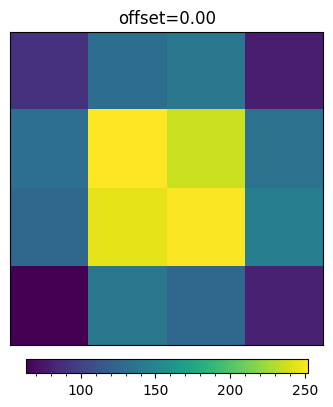

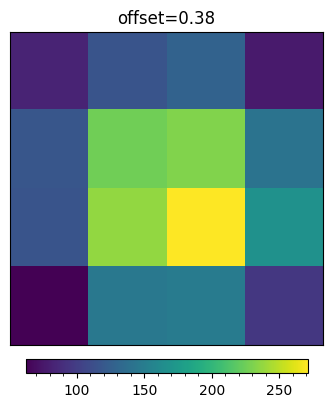

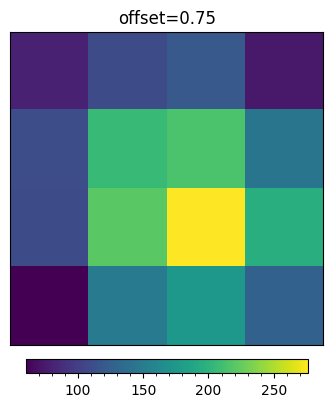

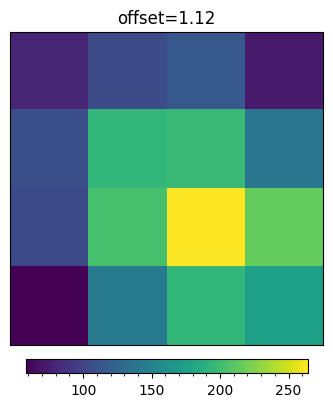

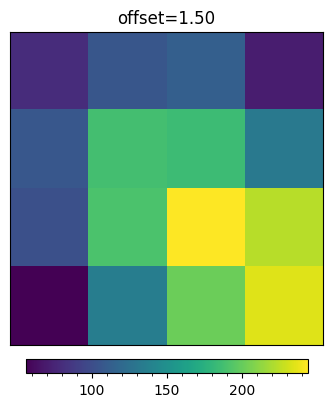

In [5]:
offsets = torch.linspace(0.0, 1.5, 5)
img_size = 4
num_objects = 2
background_intensity=50.0
for offset in offsets:
    img_simulator = ImageSimulator(img_height=img_size, 
                                img_width=img_size, 
                                num_objects=num_objects, 
                                locs_offset=offset.item(),
                                flux_list=[1000.0, 500.0], 
                                psf_stdev=1.0, 
                                background_intensity=background_intensity)
    outputs = img_simulator.generate(batch_size=2, seed=7272)
    image = outputs["images"][0]
    img_max = image.max()
    img_min = image.min()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(image.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"offset={offset.item():.2f}")
    cb = fig.colorbar(im, ax=ax, 
                    location="bottom", shrink=0.6,
                    anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [6]:
posterior_at_offset = [test_offset_and_posterior(locs_offset=offset.item(), seed=7272) for offset in offsets]

21:15:03 - cmdstanpy - INFO - compiling stan file /home/pduan/bliss/case_studies/dc2_mdt/1or2_posterior.stan to exe file /home/pduan/bliss/case_studies/dc2_mdt/1or2_posterior


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
offset: 0.00
sampling:


21:15:30 - cmdstanpy - INFO - compiled model executable: /home/pduan/bliss/case_studies/dc2_mdt/1or2_posterior
21:15:30 - cmdstanpy - INFO - CmdStan start processing
21:15:30 - cmdstanpy - INFO - Chain [1] start processing
21:15:30 - cmdstanpy - INFO - Chain [2] start processing
21:15:30 - cmdstanpy - INFO - Chain [3] start processing
21:15:30 - cmdstanpy - INFO - Chain [4] start processing
21:15:30 - cmdstanpy - INFO - Chain [4] done processing
21:15:30 - cmdstanpy - INFO - Chain [1] done processing
21:15:31 - cmdstanpy - INFO - Chain [2] done processing
21:15:31 - cmdstanpy - INFO - Chain [3] done processing


diagnose:
                  Mean        MCSE      StdDev         MAD          5%  \
lp__         52.956800    0.148446    1.348400    1.079630   50.299800   
fluxes[1]  1351.590000  235.751000  344.118000   73.507300  629.862000   
fluxes[2]   946.222000   73.697500  303.990000  277.623000  529.277000   
theta[1]      0.582492    0.110671    0.277204    0.330642    0.088464   
theta[2]      0.417507    0.110671    0.277204    0.330642    0.033374   

                   50%          95%  ESS_bulk    ESS_tail    R_hat  
lp__         53.292600    54.498000  60.98080  10000.0000  1.04642  
fluxes[1]  1522.010000  1612.730000   7.07038  10000.0000  1.52795  
fluxes[2]   902.408000  1508.930000  42.06810   9404.8500  1.05942  
theta[1]      0.618953     0.966626  15.01090     45.6581  1.17580  
theta[2]      0.381047     0.911536  15.01090     45.6581  1.17580  


21:15:32 - cmdstanpy - INFO - CmdStan start processing
21:15:32 - cmdstanpy - INFO - Chain [1] start processing
21:15:32 - cmdstanpy - INFO - Chain [2] start processing
21:15:32 - cmdstanpy - INFO - Chain [3] start processing
21:15:32 - cmdstanpy - INFO - Chain [4] start processing


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  fluxes[1], fluxes[2], theta[1], theta[2]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
offset: 0.38
sampling:


21:15:33 - cmdstanpy - INFO - Chain [3] done processing
21:15:33 - cmdstanpy - INFO - Chain [4] done processing
21:15:33 - cmdstanpy - INFO - Chain [1] done processing
21:15:33 - cmdstanpy - INFO - Chain [2] done processing


diagnose:
                 Mean      MCSE     StdDev        MAD          5%         50%  \
lp__        52.985700  0.016178   1.289760   1.039230   50.448100   53.331400   
fluxes[1]  933.786000  1.111990  96.045100  95.959800  774.639000  934.484000   
fluxes[2]  623.537000  1.073840  92.150200  92.291800  473.350000  622.532000   
theta[1]     0.332736  0.002164   0.234601   0.261641    0.024781    0.294756   
theta[2]     0.667264  0.002164   0.234601   0.261641    0.227921    0.705245   

                   95%  ESS_bulk  ESS_tail     R_hat  
lp__         54.388900   6951.50   8936.72  0.999939  
fluxes[1]  1091.800000   7487.28   7693.99  1.000580  
fluxes[2]   776.716000   7392.40   8418.92  1.000450  
theta[1]      0.772079  10569.00   8085.16  1.000420  
theta[2]      0.975219  10569.00   8085.16  1.000420  


21:15:34 - cmdstanpy - INFO - CmdStan start processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [2] start processing
21:15:34 - cmdstanpy - INFO - Chain [3] start processing
21:15:34 - cmdstanpy - INFO - Chain [4] start processing


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
offset: 0.75
sampling:


21:15:35 - cmdstanpy - INFO - Chain [3] done processing
21:15:35 - cmdstanpy - INFO - Chain [2] done processing
21:15:35 - cmdstanpy - INFO - Chain [4] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing


diagnose:
                 Mean      MCSE     StdDev        MAD          5%         50%  \
lp__        53.073000  0.014416   1.276310   1.054050   50.594200   53.395300   
fluxes[1]  985.249000  0.615725  62.858000  62.793300  882.864000  985.145000   
fluxes[2]  577.892000  0.539965  55.508700  55.254300  487.593000  577.538000   
theta[1]     0.333946  0.001962   0.235155   0.260508    0.026731    0.292521   
theta[2]     0.666054  0.001962   0.235155   0.260508    0.225760    0.707478   

                   95%  ESS_bulk  ESS_tail    R_hat  
lp__         54.464500   8422.01  10987.90  1.00038  
fluxes[1]  1089.960000  10440.70  11665.50  1.00005  
fluxes[2]   669.304000  10594.90  11936.00  1.00027  
theta[1]      0.774240  12603.60   9310.39  1.00028  
theta[2]      0.973269  12603.60   9310.39  1.00028  
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI

21:15:36 - cmdstanpy - INFO - CmdStan start processing
21:15:36 - cmdstanpy - INFO - Chain [1] start processing
21:15:36 - cmdstanpy - INFO - Chain [2] start processing
21:15:36 - cmdstanpy - INFO - Chain [3] start processing
21:15:36 - cmdstanpy - INFO - Chain [4] start processing


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
offset: 1.12
sampling:


21:15:37 - cmdstanpy - INFO - Chain [4] done processing
21:15:37 - cmdstanpy - INFO - Chain [1] done processing
21:15:37 - cmdstanpy - INFO - Chain [2] done processing
21:15:37 - cmdstanpy - INFO - Chain [3] done processing


diagnose:
                  Mean      MCSE     StdDev       MAD          5%  \
lp__         53.162100  0.014032   1.313680   1.07059   50.587600   
fluxes[1]  1003.810000  0.478802  52.392600  52.61010  918.909000   
fluxes[2]   558.717000  0.379230  42.561600  42.85680  489.425000   
theta[1]      0.334249  0.001804   0.237053   0.26285    0.024193   
theta[2]      0.665751  0.001804   0.237053   0.26285    0.221664   

                   50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__         53.499300    54.586400   9173.11   12114.6  0.999986  
fluxes[1]  1003.750000  1089.610000  12070.30   12583.7  1.000200  
fluxes[2]   558.855000   629.392000  12602.70   14176.7  1.000100  
theta[1]      0.292975     0.778337  14672.60   10547.3  1.000170  
theta[2]      0.707025     0.975807  14672.50   10547.3  1.000170  
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Che

21:15:38 - cmdstanpy - INFO - CmdStan start processing
21:15:38 - cmdstanpy - INFO - Chain [1] start processing
21:15:38 - cmdstanpy - INFO - Chain [2] start processing
21:15:38 - cmdstanpy - INFO - Chain [3] start processing
21:15:38 - cmdstanpy - INFO - Chain [4] start processing


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
offset: 1.50
sampling:


21:15:38 - cmdstanpy - INFO - Chain [1] done processing
21:15:38 - cmdstanpy - INFO - Chain [3] done processing
21:15:38 - cmdstanpy - INFO - Chain [2] done processing
21:15:38 - cmdstanpy - INFO - Chain [4] done processing


diagnose:
                  Mean      MCSE     StdDev        MAD          5%  \
lp__         52.727400  0.013671   1.305920   1.056350   50.132800   
fluxes[1]  1014.500000  0.402154  47.295700  47.028100  937.583000   
fluxes[2]   550.286000  0.298405  35.975000  35.741000  492.051000   
theta[1]      0.334917  0.001670   0.235239   0.262776    0.025610   
theta[2]      0.665083  0.001670   0.235239   0.262776    0.224114   

                   50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__         53.072200    54.140000   9395.56   12509.2  1.000020  
fluxes[1]  1014.130000  1093.700000  13871.80   14303.2  0.999959  
fluxes[2]   549.699000   610.532000  14533.80   13922.8  1.000130  
theta[1]      0.295254     0.775886  16805.30   10251.1  1.000080  
theta[2]      0.704746     0.974390  16805.20   10251.1  1.000080  
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found

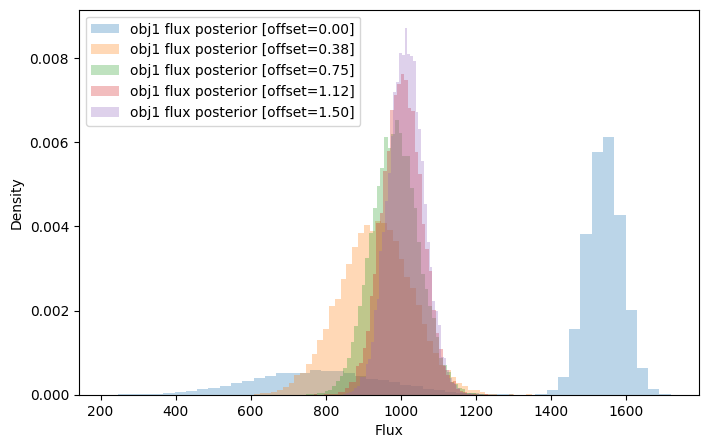

In [7]:
plt.figure(figsize=(8, 5))
for p, offset in zip(posterior_at_offset, offsets, strict=True):
    plt.hist(p["fluxes[1]"].to_numpy(), 
             bins=50, 
             density=True, 
             alpha=0.3, 
             label=f"obj1 flux posterior [offset={offset.item():.2f}]")
plt.legend()
plt.xlabel("Flux")
plt.ylabel("Density")
plt.show()

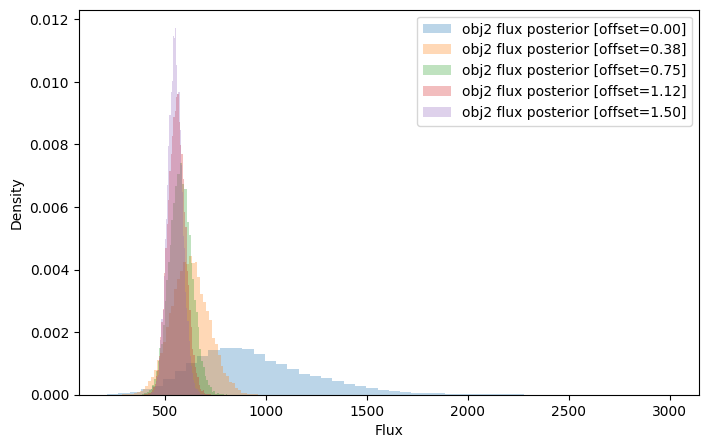

In [8]:
plt.figure(figsize=(8, 5))
for p, offset in zip(posterior_at_offset, offsets, strict=True):
    plt.hist(p["fluxes[2]"].to_numpy(), 
             bins=50, 
             density=True, 
             alpha=0.3, 
             label=f"obj2 flux posterior [offset={offset.item():.2f}]")
plt.legend()
plt.xlabel("Flux")
plt.ylabel("Density")
plt.show()